# 9.4 Slow Feature Analysis (SFA)
Slow Feature Analysis (SFA)とは, 複数の時系列データの中から低速に変化する成分 (slow feature) を抽出する教師なし学習のアルゴリズムである (Laurenz Wiskott, Berkes, Franzius, Sprekeler, & Wilbert, 2011; L. Wiskott & Sejnowski, 2002)．

数学的な詳細は省略するが，潜在変数 $y$ の時間変化の2乗である $\left(\frac{dy}{dt}\right)^2$を最小にするように教師なし学習を行う．初期視覚野の受容野や格子細胞・場所細胞などのモデルに応用がされている (Franzius, Sprekeler, & Wiskott, 2007)．

生理学的妥当性についてはいくつかの検討がされている．(Sprekeler, Michaelis, & Wiskott, 2007)ではSTDP則によりSFAが実現できることを報告している．ただし，in vivoにおけるSTDPの存在については近年疑問視されている．これまでのin vitroでの実験は細胞外Ca濃度が高かったために、pre/postのスパイクの時間差でLTD/LTPが生じるという「古典的STDP則」が生じていた可能性があり，細胞外Ca濃度をin vivoの水準まで下げると古典的STDP則は起こらないという報告がある (Inglebert, Aljadeff, Brunel, & Debanne, 2020)．古典的な線形Recurrent neural networkでの実装も提案されている ([Lipshutz, Windolf, Golkar, & Chklovskii, 2020](https://arxiv.org/abs/2010.12644))．


In [4]:
using PyPlot, Statistics, LinearAlgebra

### SFAの前処理

SFAの前処理として多項式展開(polynomial expandsion)が用いられる ([Berkes & Wiskott, 2005](https://jov.arvojournals.org/article.aspx?articleid=2192836))．Pythonにおいては[sklearn.preprocessing.PolynomialFeatures](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html)により使用できる．

In [32]:
monomials(n, d) = [t for t in Base.product(ntuple(i->0:d, Val{n}())...) if sum(t)<=d && sum(t) > 0]
polynomial_expand(X, d) =  hcat([[prod(X[i, :] .^ m) for m in monomials(size(X)[2], d)] for i in 1:size(X)[1]]...)'

whiten(X) = (X .- mean(X, dims=1)) ./ std(X, dims=1)

whiten (generic function with 1 method)

### データセットの生成

In [21]:
# create the input signal
nt = 5000;
t = range(0, 2*π, length=nt)

x1 = sin.(t) + 2*cos.(11*t).^2;
x2 = cos.(11*t);

X = [x1 x2];

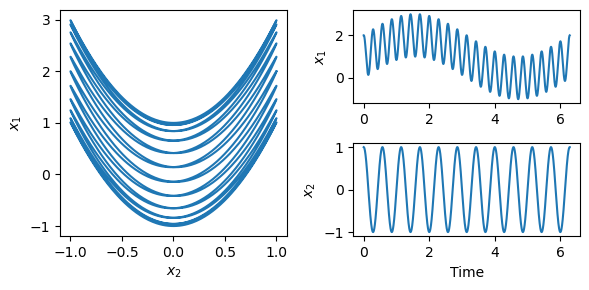

In [29]:
figure(figsize=(6, 3))
subplot2grid((2, 2), (0, 0), rowspan=2)
plot(x2, x1)
xlabel(L"$x_2$"); ylabel(L"$x_1$")
subplot2grid((2, 2), (0, 1))
plot(t, x1)
ylabel(L"$x_1$")
subplot2grid((2, 2), (1, 1))
plot(t, x2)
xlabel("Time"); ylabel(L"$x_2$")
tight_layout()

### SFAの実装

In [34]:
# Linear slow feature analysis
function linsfa(X)
    # X ∈ R^(dims x timesteps)
    Xw = whiten(X)
    _, _, V = svd(diff(Xw, dims=1))
    return Xw[1:end-1, :] * V[:, end];
end

linsfa (generic function with 1 method)

### 実行と結果表示

In [35]:
y = linsfa(polynomial_expand(X, 2));

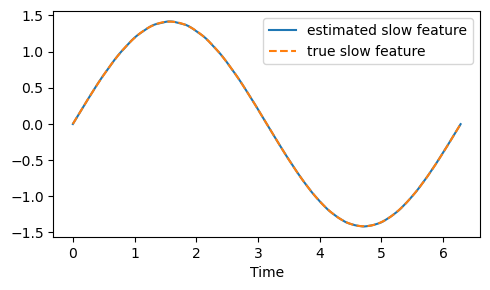

In [43]:
figure(figsize=(5, 3))
plot(t[1:end-1], whiten(y), label="estimated slow feature")
plot(t[1:end-1], whiten(sin.(t[1:end-1])), "--", label="true slow feature")
xlabel("Time"); legend();
tight_layout()

## aaa

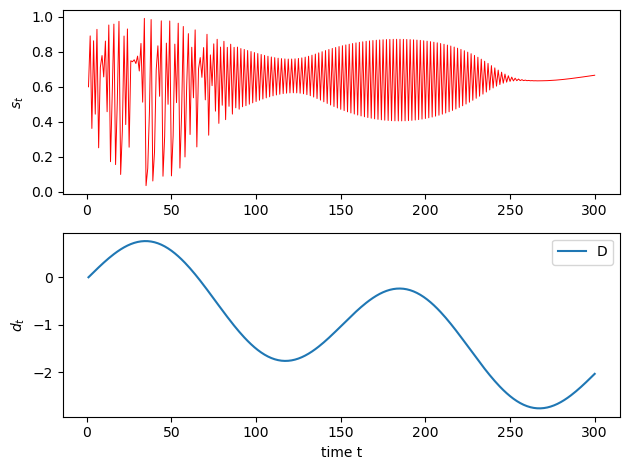

In [58]:
series_length = 300
S = zeros(series_length)
D = zeros(series_length)

S[1] = 0.6
for t in 1:series_length-1
    D[t+1] = sin(π/75. * t) - t/150.
    S[t+1] = (3.7+0.35*D[t+1]) * S[t] * (1 - S[t])
end

subplot(2,1,1)
plot(1:series_length, S, "r", linewidth=0.7, label="S")
ylabel(L"$s_t$")
subplot(2,1,2)
plot(1:series_length, D,  label="D")
xlabel("time t")
ylabel(L"$d_t$")
legend()
tight_layout()

Copy delayed version of the input signal on the space dimensions.

In [169]:
time_frames(X, d) = hcat([X[i:end-d+i] for i in 1:d]...)

time_frames (generic function with 1 method)

In [175]:
Stf = time_frames(S, 2);

In [176]:
Y = whiten(polynomial_expand(Stf, 3));
_, _, V = svd(diff(Y, dims=1));

In [177]:
Z = Y[1:end-1, :] * V[:, end];

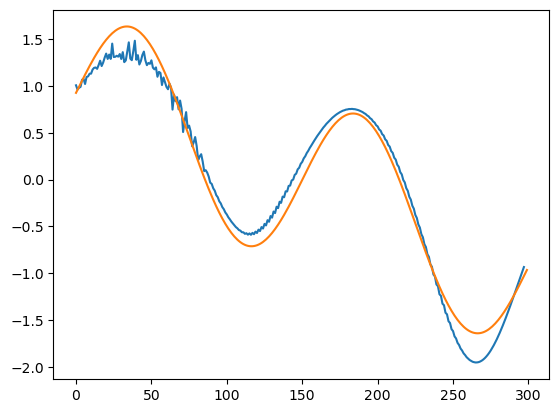

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x0000000062C066C8>

In [179]:
plot(whiten(Z)*-1)
plot(whiten(D))

In [ ]:
m = 4;
ii = rand(m);
M = ii * ii'

In [ ]:
T = 

In [ ]:
W = rand()

In [ ]:
#for t = 1:T
a[t] = W * x[t] #project inputs
while true
    ytm1 = copy(y[t])
    y[t] += γ * (a[t] − M * y[t]) # compute neural output
    Δy = abs(y[t]-ytm1) 

    #until convergence
    if Δy .< 1
        break
    end
end
x̄t = x[t] + x[t−1]
y¯t = y[t] + y[t−1]
# synaptic updates
W += 2η*(y¯t * x¯t' − a[t] * x[t]')
M += η/τ * (y¯t * y¯t' − M)
#end

- https://towardsdatascience.com/a-brief-introduction-to-slow-feature-analysis-18c901bc2a58
- https://github.com/flatironinstitute/bio-sfa/blob/master/timeseries.ipynb
- https://github.com/flatironinstitute/bio-sfa
- https://github.com/fulviadelduca/slow-feature-analysis

Deep Slow Feature Analysis Network
https://github.com/rulixiang/DSFANet

https://nbviewer.jupyter.org/github/pierrelux/notebooks/blob/master/Slow%20Feature%20Analysis.ipynb

http://www.cfme.chiba-u.jp/~haneishi/class/iyogazokougaku/SVD.pdf


sklearn.preprocessing.PolynomialFeatures